# Import packages

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from numpy import mat
from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import math as m
import os

# Settings of the algorithm

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
tfd = tf.contrib.distributions
tfb = tfd.bijectors
layers = tf.contrib.layers
tf.VERSION
sess = tf.InteractiveSession()
tf.set_random_seed(0)
DTYPE=tf.float32
NP_DTYPE=np.float32
MODEL = 'NFLMC' 
TARGET_DENSITY = 'RING' 

# dataset-specific settings
settings = {
    'RING':{
        'batch_size': 200,
        'num_bijectors': 4,
        'train_iters': 2e3,
        'epsilon': 2e-6,
        'langevin':2
    }
    
}

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import ops
from tensorflow.python.layers import core as layers
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import template as template_ops
from tensorflow.python.ops.distributions import bijector
from tensorflow.python.util import deprecation
from tensorflow.python.ops import clip_ops



__all__ = [
    "LNF",
    "LNF_default_template"
]

# Probability density function of RING and its gradient function

In [5]:
def log_p(x):
    x1 = x[:,:1]
    x2 = x[:,1:]
    ux = tf.square(tf.sqrt(tf.square(x1) + tf.square(x2)) - 2.0) / 0.32
    return -ux


def DDU(x,mask):
    x1 = x[:,:1]
    x2 = x[:,1:]
    pub = tf.square(x1) + tf.square(x2)
    c = 2.0 / 0.32
    a = 2  * tf.sqrt(pub)
    b = tf.sqrt(tf.pow(pub, 3)) + 1e-3
    d = 1.0 / b
    if mask == 0:
        return -c * (1.0 - (a + d) / (pub + 1e-3))
    else:
        return -c * (1.0 - (a + d) / (pub + 1e-3))

    
def DU(x, mask):
    x1 = x[:,:1]
    x2 = x[:,1:]
    pub = tf.sqrt(tf.square(x1) + tf.square(x2))
    if mask == 0:
        return -((pub - 2.0) / 0.32) * (1 / (pub+1e-3)) * 2.0 * (x1)
    else:
        return -((pub - 2.0) / 0.32) * (1 / (pub+1e-3)) * 2.0 * (x2)

# Implementation of Langevin normalization flows

In [7]:
class LNF(bijector.Bijector):
    def __init__(self,
               num_masked,
               shift_and_log_scale_fn,
               is_constant_jacobian=False,
               validate_args=False,
               name=None):
        name = name or "LNF"
        if num_masked <= 0:
            raise ValueError("num_masked must be a positive integer.")
        self._num_masked = num_masked
        # At construction time, we don't know input_depth.
        self._input_depth = None
        self.epsilon = 1e-4
        self._shift_and_log_scale_fn = shift_and_log_scale_fn
        self.m = 3
        super(LNF, self).__init__(
            #forward_min_event_ndims=1,#may be useful for different version of tensorflow
            is_constant_jacobian=is_constant_jacobian,
            validate_args=validate_args,
            name=name)

        
    def _cache_input_depth(self, x):
        if self._input_depth is None:
            self._input_depth = x.shape.with_rank_at_least(1)[-1].value
            if self._input_depth is None:
                raise NotImplementedError(
                    "Rightmost dimension must be known prior to graph execution.")
            if self._num_masked >= self._input_depth:
                raise ValueError(
                    "Number of masked units must be smaller than the event size.")

                
    def _forward(self, x):#my forward function
        self._cache_input_depth(x)
        # Performs scale and shift.
        x0, x1 = x[:, :self._num_masked], x[:, self._num_masked:]
        shift, log_scale = self._shift_and_log_scale_fn(x0, self._input_depth - self._num_masked)
        y0 = x0
        y1 = x1 
        for i in range(self.m):
            x = array_ops.concat([x0, y1], axis=-1)
            gradient_x = DU(x, 1)
            y1 += self.epsilon * self.epsilon / 2 * gradient_x + self.epsilon * math_ops.exp(log_scale)
        if log_scale is not None:
            y1 *= math_ops.exp(log_scale)
        if shift is not None:
            y1 += shift
        y = array_ops.concat([y0, y1], axis=-1)
        shift1, log_scale1 = self._shift_and_log_scale_fn(y1, self._input_depth - self._num_masked)
        z1 = y1
        z0 = y0
        for i in range(self.m):
            y = array_ops.concat([z0, y1], axis=-1)
            gradient_y = DU(y, 0)
            z0 += self.epsilon * self.epsilon / 2 * gradient_y + self.epsilon * math_ops.exp(log_scale1)
        if log_scale1 is not None:
            z0 *= math_ops.exp(log_scale1)
        if shift1 is not None:
            z0 += shift1
        z = array_ops.concat([z0, z1], axis=-1)
        return z

            
    def _forward_log_det_jacobian(self, x):
        self._cache_input_depth(x)
        x0, x1 = x[:, :self._num_masked], x[:, self._num_masked:]
        shift, log_scale = self._shift_and_log_scale_fn(x0, self._input_depth - self._num_masked)
        if log_scale is None:
            return constant_op.constant(0., dtype=x.dtype, name="fldj_x")
        y0 = x0
        y1 = x1 
        result = math_ops.reduce_sum(log_scale, axis=-1)
        tmp = tf.ones((x.get_shape()[0].value,1))
        for i in range(self.m):
            x = array_ops.concat([x0, y1], axis=-1)
            gradient_x = DU(x, 1)
            y1 += self.epsilon * self.epsilon / 2 * gradient_x + self.epsilon * math_ops.exp(log_scale)
            tmp += self.epsilon * self.epsilon / 2 * DDU(x,1)
        result += math_ops.log(1e-8 + math_ops.reduce_sum(tmp,axis=-1))

        if log_scale is not None:
            y1 *= math_ops.exp(log_scale)
        if shift is not None:
            y1 += shift
        _, log_scale1 = self._shift_and_log_scale_fn(y1, self._input_depth - self._num_masked)
        if log_scale1 is None:
            return constant_op.constant(0., dtype=x.dtype, name="fldj_y")
        result += math_ops.reduce_sum(log_scale1, axis=-1)
        z1 = y1
        z0 = y0
        tmp = tf.zeros((y0.get_shape()[0].value,1))
        for i in range(self.m):
            y = array_ops.concat([z0, y1], axis=-1)
            gradient_y = DU(y, 0)
            z0 += self.epsilon * self.epsilon / 2 * gradient_y + self.epsilon * math_ops.exp(log_scale1)
            tmp += math_ops.square(self.epsilon) / 2 * DDU(y,0)
        result += math_ops.log(1e-8 + math_ops.reduce_sum(tmp,axis=-1))
        return result
    
    
    def _inverse(self, z):
        self._cache_input_depth(z)
        # Performs un-shift and un-scale.
        z0, z1 = z[:, :self._num_masked], z[:, self._num_masked:]
        shift, log_scale = self._shift_and_log_scale_fn(z1, self._input_depth - self._num_masked)
        y1 = z1
        y0 = z0
        if shift is not None:
            y0 -= shift 
        if log_scale is not None:
            y0 *= math_ops.exp(-log_scale)
        for i in range(self.m):
            y0 -= self.epsilon * math_ops.exp(log_scale)
            y_ = array_ops.concat([y0, y1], axis=-1)
            gradient_y = DU(y_, 0)
            y0 -= self.epsilon * self.epsilon / 2 * gradient_y
        y = array_ops.concat([y0, y1], axis=-1)
        x0 = y0
        x1 = y1
        shift1, log_scale1 = self._shift_and_log_scale_fn(y0, self._input_depth - self._num_masked)
        if shift1 is not None:
            x1 -= shift1 
        if log_scale1 is not None:
            x1 *= math_ops.exp(-log_scale1)
        for i in range(self.m):
            x1 -= self.epsilon *math_ops.exp(log_scale1)
            x_ = array_ops.concat([x0, x1], axis=-1)
            gradient_x = DU(x_, 1)
            x1 -= self.epsilon * self.epsilon / 2 * gradient_x
        x = array_ops.concat([x0, x1], axis=-1)
        return x  

    
    def _inverse_log_det_jacobian(self, z):
        self._cache_input_depth(z)
        z0, z1 = z[:, :self._num_masked], z[:, self._num_masked:]
        shift, log_scale = self._shift_and_log_scale_fn(z1, self._input_depth - self._num_masked)
        if log_scale is None:
            return constant_op.constant(0., dtype=y.dtype, name="ildj")
        y1 = z1
        y0 = z0
        result = math_ops.exp(-log_scale)
        if shift is not None:
            y0 -= shift 
        if log_scale is not None:
            y0 *= math_ops.exp(-log_scale)
        for i in range(self.m):
            y0 -= self.epsilon *math_ops.exp(log_scale)
            y_ = array_ops.concat([y0, y1], axis=-1)
            gradient_y = DU(y_, 0)
            y0 -= self.epsilon * self.epsilon / 2 * gradient_y
            result -= math_ops.square(self.epsilon) / 2 * DDU(y_,0) * math_ops.exp(-log_scale)
        result =math_ops.log(1e-8+math_ops.reduce_sum(result, axis=-1)) 
        x0 = y0
        x1 = y1
        shift1, log_scale1 = self._shift_and_log_scale_fn(y0, self._input_depth - self._num_masked)
        result1 = math_ops.exp(-log_scale1)
        if shift1 is not None:
            x1 -= shift1 
        if log_scale1 is not None:
            x1 *= math_ops.exp(-log_scale1)
        for i in range(self.m):
            x1 -= self.epsilon * math_ops.exp(log_scale1)
            x_ = array_ops.concat([x0, x1], axis=-1)
            gradient_x = DU(x_, 1)
            x1 -= self.epsilon * self.epsilon / 2 * gradient_x
            result1 -= self.epsilon * self.epsilon / 2 * DDU(x_,1) * math_ops.exp(-log_scale1)
        result1 =math_ops.log(1e-8+math_ops.reduce_sum(result1, axis=-1))
        return result + result1
        
      
    
#Neural networks template used in NFLMC
def LNF_default_template(
    hidden_layers,
    activation=nn_ops.relu,
    shift_only=False,
    log_scale_min_clip=-5.,
    log_scale_max_clip=3.,
    log_scale_clip_gradient=False,
    name=None,
    *args,
    **kwargs): 
    def _clip_by_value_preserve_grad(x, clip_value_min, clip_value_max, name=None):
        with ops.name_scope(name, "clip_by_value_preserve_grad",[x, clip_value_min, clip_value_max]):
            clip_x = clip_ops.clip_by_value(x, clip_value_min, clip_value_max)
            return x + array_ops.stop_gradient(clip_x - x)
    with ops.name_scope(name, "LNF_default_template"):
        def _fn(x, output_units):
            for units in hidden_layers:
                x = layers.dense(
                    inputs=x,
                    units=units,
                    activation=activation,
                    *args,
                    **kwargs)
            x = layers.dense(
              inputs=x,
              units=(1 if shift_only else 2) * output_units,
              activation=None,
              *args,
              **kwargs)
            if shift_only:
                return x, None
            shift, log_scale = array_ops.split(x, 2, axis=-1)
            which_clip = (math_ops.clip_by_value if log_scale_clip_gradient else _clip_by_value_preserve_grad)
            log_scale = which_clip(log_scale, log_scale_min_clip, log_scale_max_clip)
            return shift, log_scale
        return template_ops.make_template("LNF_default_template", _fn)


# Construct the complete Langevin normalization flows

In [9]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2],DTYPE))
num_bijectors = settings[TARGET_DENSITY]['num_bijectors']
bijectors = []


for i in range(num_bijectors):
    if MODEL == 'NFLMC':
        bijectors.append(LNF(num_masked = 1,shift_and_log_scale_fn=LNF_default_template(hidden_layers=[512, 512])))
flow_bijector = tfb.Chain(list(reversed(bijectors)))
dist = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=flow_bijector)


# visualization
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]


for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)

# Loss funtions and training procedures

24.6054
0 steps: 	 loss: 24.0956
1000 steps: 	 loss: 2.37616
2000 steps: 	 loss: 2.37538
3000 steps: 	 loss: 2.34128
4000 steps: 	 loss: 2.35543
5000 steps: 	 loss: 2.26068
6000 steps: 	 loss: 2.26859
7000 steps: 	 loss: 2.20388
8000 steps: 	 loss: 2.1556
9000 steps: 	 loss: 2.15832


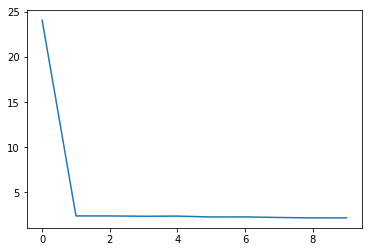

In [11]:
Q = dist.log_prob(samples[-1])
P = log_p(samples[-1])
q = tf.exp(Q)
p = tf.exp(P)
P = tf.log(p / 40 + 1e-8)
loss = tf.reduce_mean(tf.square(Q-P))


train_op = tf.train.AdamOptimizer(2e-4).minimize(loss)
sess.run(tf.global_variables_initializer())
print(loss.eval())


NUM_STEPS = int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
np_losses = []
mmd_my = []
NUM_STEPS = int(1e4)


for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 1000== 0:
        global_step.append(i)
        np_losses.append(np_loss)
        print(i,'steps:','\t loss:',np_loss)

        
plt.plot(np_losses)
plt.show()

# Draw samples

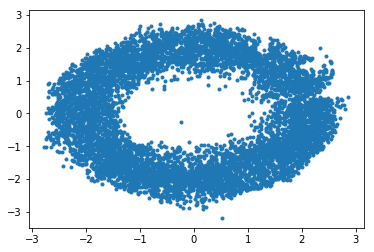

In [16]:
results = sess.run(samples)
plt.scatter(results[-1][:,:1],results[-1][:,1:],marker='.')
plt.show()